# Determining the cost of cars

The application for quickly finding out the market value of your car, needs a machine learning tool capable of predicting price. Historical data is available: technical characteristics, configurations and prices of vehicles. Service to attract new customers will be built on the basis of this model. The following metrics are important:
- quality of prediction;
- prediction speed;
- studying time.

## Data preparation

In [1]:
#pip install catboost --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [2]:
#!pip install lightgbm

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder

In [4]:
#Importing data
import os

pth1 = '/datasets/autos.csv'
pth2 = 'D:\\Python\\Jupyter\\autos.csv'
pth3 = 'D:\\Kate\\Python\\jupyter\\autos.csv'
pth4 = 'C:\\Users\\user\\Documents\\jupyter\\autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
elif os.path.exists(pth4):
    df = pd.read_csv(pth4)
else:
    print('Something is wrong')

In [5]:
#Displaying the data
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
#Information about the data provided
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

From the project documentation:

* `DateCrawled` — date of downloading from the database
* `VehicleType` — car body type
* `RegistrationYear` - year of car registration
* `Gearbox` — gear box type
* `Power` - power (hp)
* `Model` — car model
* `Kilometer` — mileage (km)
* `RegistrationMonth` — car registration month
* `FuelType` — fuel type
* `Brand` — car brand
* `Repaired` - was the car under repair or not
* `DateCreated` — date of creation of the questionnaire
* `NumberOfPictures` - the number of photos of the car
* `PostalCode` — postal code of the owner of the profile (user)
* `LastSeen` — date of last user activity

To preprocess the data, do the following:
1. Rename columns according to good style
2. Replace data types
3. Discard non-essential data columns
4. Check values for abnormal
5. Get rid of gaps
6. Remove duplicates
7. Check for correlation

In [1]:
#Splitting column names into words
df = df.rename(columns={'DateCrawled': 'Date Crawled', 'VehicleType': 'Vehicle Type', 'RegistrationYear': 'Registration Year', 'RegistrationMonth': 'Registration Month', 'FuelType': 'Fuel Type', 'NumberOfPictures': 'Number Of Pictures', 'PostalCode': 'Postal Code', 'LastSeen': 'Last Seen'})

NameError: name 'df' is not defined

In [8]:
#Add an underscore instead of a space
df.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)

In [9]:
df.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,datecreated,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Translate the date data into the datetime type and check which time range the data belongs to

<AxesSubplot:>

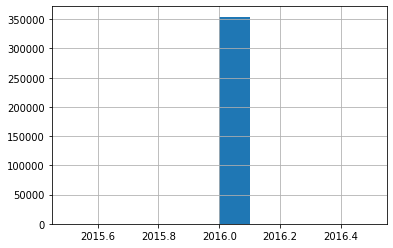

In [10]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_crawled'].dt.year.hist()

Check the data on the number of photos.

<AxesSubplot:>

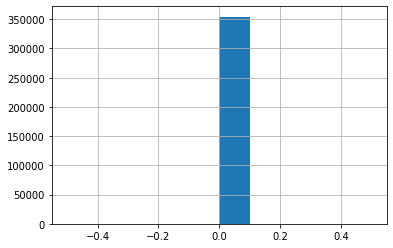

In [11]:
df['number_of_pictures'].hist()

All data refer to 2016, so let's delete this column. In all rows of the column with the number of photos is 0, delete this column as well. Remove the columns with the month of registration, the time the profile was created, the postal code, and the time of the last activity.

In [12]:
columns_to_drop = ['date_crawled','registration_month', 'datecreated', 'number_of_pictures', 'postal_code', 'last_seen']
df = df.drop(columns=columns_to_drop)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Check the numerical data for anomalies

In [13]:
df.describe()

,price,registration_year,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


1. Value column contains zero values and possibly unrealistically small values
2. There are anomalous values in the column with the year of registration
3. There are also anomalous values in `power` and `kilometer`

First, let's deal with the anomalous values in the columns with power and mileage. It is proposed to replace all values lying outside the limits of three sigma by the nearest neighbor method

In [ ]:
#Столбцы для замены
cols_to_impute = ['power', 'kilometer']
df_selected = df[cols_to_impute]

#Оставляем только значения в пределах трех сигм
df_selected = df_selected[(df - df_selected.mean()).abs() <= 3 * df_selected.std()]

#Воспользуемся методом ближайщих соседей для заполнения образовавшихся пропусков
imputer = KNNImputer()
df_imputed = imputer.fit_transform(df_selected)

#Заменим значения в столбцах и проверим датафрейм
df[cols_to_impute] = df_imputed
df.head()

/tmp/ipykernel_48/1417205025.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_selected = df_selected[(df - df_selected.mean()).abs() <= 3 * df_selected.std()]


Gaps in the `repaired` column are interpreted as `no`

In [ ]:
df['repaired'].fillna(value='no', inplace = True)
df.reset_index(drop = True, inplace = True)
df

Check unique values in columns `vehicle_type`, `gearbox`, `model`, `fuel_type` and `brand`

In [ ]:
df['vehicle_type'].unique()

In [ ]:
df['gearbox'].unique()

In [ ]:
df['model'].unique()

In [ ]:
df['fuel_type'].unique()

In [ ]:
df['brand'].unique()

Remove the missing values in the `gearbox` column, in other cases, you can replace the gaps with the value `other`, since it is already there.

In [ ]:
df.dropna(subset=['gearbox'], inplace=True)
df.info()

In [ ]:
df.fillna(value='other', inplace = True)
df.reset_index()
df.info()

There are no passes left. Ab values in the column with the price will have to be removed

In [ ]:
df = df[(df['price'] > df['price'].mean() - 3 * df['price'].std()) & (df['price'] < df['price'].mean() + 3 * df['price'].std())]
df.reset_index(drop = True, inplace = True)
df

Abnormal values in the column with the year of registration will be replaced according to the following scheme: delete values less than 1970 and more than 2016 (since this is the date of downloading the questionnaires)

In [ ]:
df = df[(df['registration_year'] > 1970) & (df['registration_year'] < 2016)]
df.reset_index(drop = True, inplace = True)
df.info()

Check for duplicates

In [ ]:
df.duplicated().sum()

The data contains a sufficiently large number of duplicates, they will have to be removed.

In [ ]:
df = df.drop_duplicates().reset_index(drop=True) 
df.duplicated().sum()

Build a heat map of quantitative data correlation

In [ ]:
sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot=True)
plt.show()

**Conclusion:**
  1. The data contained a large number of anomalous values, gaps and duplicates.
  2. After preprocessing the data, it was possible to save 260706 lines out of 354369, which is approximately 73%.
  3. There is a slight correlation between two features: year of registration and mileage.
  5. Data is prepared and ready for model training.

## Model training

Split into two samples: training and test

In [ ]:
#Target - car price
target = df['price']

#Features
features = df.drop(['price'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train = features_train.reset_index()
features_test = features_test.reset_index()

#Check sample shapes
print(features_train.shape, features_test.shape)

In [ ]:
ohe = OneHotEncoder(drop='first')

categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

train_ohe = features_train.copy()
test_ohe = features_test.copy()

# Applying OneHotEncoder to categorical features on the training and test sets
ohe_train = ohe.fit_transform(train_ohe[categorical_features])
ohe_test = ohe.transform(test_ohe[categorical_features])
                         
train_ohe_encoded = pd.DataFrame(ohe_train.toarray(), columns=ohe.get_feature_names(categorical_features))
test_ohe_encoded = pd.DataFrame(ohe_test.toarray(), columns=ohe.get_feature_names(categorical_features))  

train_ohe.drop(categorical_features, axis=1, inplace=True)
test_ohe.drop(categorical_features, axis=1, inplace=True)
train_ohe = pd.concat([train_ohe, train_ohe_encoded], axis=1)
test_ohe = pd.concat([test_ohe, test_ohe_encoded], axis=1)
                         
train_ohe.set_index('index', inplace = True)
test_ohe.set_index('index', inplace = True)
train_ohe

In [ ]:
encoder = OrdinalEncoder()

train_oe = features_train.copy()
test_oe = features_test.copy()

# Applying OrdinalEncoder to categorical features on the training and test sets
oe_train = encoder.fit_transform(train_oe[categorical_features])
oe_test = encoder.transform(test_oe[categorical_features])
                         
train_oe_encoded = pd.DataFrame(oe_train, columns=categorical_features)
test_oe_encoded = pd.DataFrame(oe_test, columns=categorical_features)

train_oe.drop(categorical_features, axis=1, inplace=True)
test_oe.drop(categorical_features, axis=1, inplace=True)
train_oe = pd.concat([train_oe, train_oe_encoded], axis=1)
test_oe = pd.concat([test_oe, test_oe_encoded], axis=1)
                         
train_oe.set_index('index', inplace = True)
test_oe.set_index('index', inplace = True)

train_oe.head()

Standardize the samples. Train the StandardScaler on the training set and apply it to the training and test sets.

In [ ]:
scaler = StandardScaler()

# Scale features in train_ohe and test_ohe dataframes
train_ohe = scaler.fit_transform(train_ohe)
test_ohe= scaler.transform(test_ohe)

# Scale features in train_oe and test_oe dataframes
train_oe = scaler.fit_transform(train_oe)
test_oe = scaler.transform(test_oe)
pd.options.mode.chained_assignment = None
test_oe

Use RMSE as the main metric. Write a function for this metric

In [ ]:
def rmse(y_true, y_pred):
    y_pred = pd.Series(y_pred)
    return mean_squared_error(y_true, y_pred, squared = False)

In [ ]:
scorer = make_scorer(rmse, greater_is_better=False)

Consider several models:
1. **Ridge** is a linear regression model with L2 regularization. It is one of the classic machine learning models and is commonly used to predict numerical values.

2. **DecisionTree** is a decision tree model that builds a decision tree based on given features. It is used to solve classification and regression.

3. **CatBoost** is a gradient boosting algorithm developed by Yandex. It is based on decision trees and is designed to solve classification and regression. CatBoost has a number of advantages over other boosting algorithms, such as resistance to overfitting, the ability to work with categorical features, and fast training time.

4. **LGBM** is a gradient boosting algorithm that uses a histogram approach to build decision trees. It is designed to solve classification and regression problems and is one of the fastest and most efficient gradient boosting algorithms.

5. **Dummy** is a dummy model that is used as the base model when compared to other models. Dummy does not make any predictions and always returns a constant value that can be set by the user. It can be used to test the quality of other models and determine how well a model performs compared to a simple stub model.

Each of these models will be compared according to three characteristics:
1. Learning time
2. Time prediction
3. RMSE value

Use GridSearhCV for cross-validation and hyperparameter search.

In [ ]:
%%time
#Linear regression
model = Ridge()

# Create a hyperparameter grid
params = {'alpha': np.logspace(-3, 3, 7)}

grid_search = GridSearchCV(model, params, cv=5, scoring = scorer)

# Model training on data using GridSearchCV
grid_search.fit(train_ohe, target_train)

In [ ]:
%%time

# best parameters
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
rmse_ridge = -grid_search.best_score_

time_fit_ridge = grid_search.cv_results_['mean_fit_time'].sum()
time_pred_ridge = grid_search.cv_results_['mean_score_time'].sum()

print("Best Hyperparameters:", grid_search.best_params_)
print("RMSE: ", rmse_ridge)
print("Mean fit time:", time_fit_ridge)
print("Mean score time:", time_pred_ridge)

The model works very fast, also, according to the customer's requirement, the RMSE metric should be less than 2500, Ridge satisfies this criterion.

In [ ]:
%%time
# Create a hyperparameter grid
param_grid = { 'max_depth': range (1,101, 10),
              'min_samples_leaf': range (1,20, 2),
              'min_samples_split': range (1,20,2) }

# Decision Tree Model
regressor = DecisionTreeRegressor(random_state=12345)

grid_search = GridSearchCV(regressor, param_grid, scoring = scorer, cv=5)
    
# Fitting
grid_search.fit(train_oe, target_train)


In [ ]:
%%time

# Best parameters
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
rmse_tree = -grid_search.best_score_

time_fit_tree = grid_search.cv_results_['mean_fit_time'].sum()
time_pred_tree = grid_search.cv_results_['mean_score_time'].sum()

print("Best Hyperparameters:", best_params)
print("RMSE: ", rmse_tree)
print("Mean fit time:", time_fit_tree)
print("Mean score time:", time_pred_tree)

The Decision Tree model showed the best RMSE value, but an extremely long training time.

In [ ]:
%%time

# Create a hyperparameter grid
params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000]
}

# CatBoostRegressor
model = CatBoostRegressor(random_state=12345)

# Fitting
grid_search = GridSearchCV(model, param_grid=params, scoring = scorer, cv=5)
grid_search.fit(train_oe, target_train)

In [ ]:
%%time

best_model_cat = grid_search.best_estimator_
rmse_CatBoost = -grid_search.best_score_ 

time_fit_cat = grid_search.cv_results_['mean_fit_time'].sum()
time_pred_cat = grid_search.cv_results_['mean_score_time'].sum()

print("Best Hyperparameters:", grid_search.best_params_)
print("RMSE:", rmse_CatBoost)
print("Mean fit time:", time_fit_cat)
print("Mean score time:", time_pred_cat)

CatBoost gives good RMSE and also training and prediction is faster.

In [ ]:
%%time

#LGBMRegressor
model_LGBM = LGBMRegressor()

# Create a hyperparameter grid
params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [5, 10, 15]
}

#Fitting
grid = GridSearchCV(estimator=model_LGBM, param_grid=params, cv=5, scoring=scorer)
grid.fit(train_oe, target_train)

In [ ]:
%%time

best_model = grid.best_estimator_
rmse_LGBM = -grid.best_score_

time_fit_LGBM = grid.cv_results_['mean_fit_time'].sum()
time_pred_LGBM = grid.cv_results_['mean_score_time'].sum()

print("Best Hyperparameters:", grid.best_params_)
print("RMSE:", rmse_LGBM)
print("Mean fit time:", time_fit_LGBM)
print("Mean score time:", time_pred_LGBM)

The LightGBM boosting algorithm also gives a good RMSE metric while learning faster. The prediction time is the longest.

In [ ]:
%%time

#Compare values with constant model
dummy = DummyRegressor()
dummy.fit(train_oe, target_train)

In [ ]:
%%time

pred_dummy = dummy.predict(test_oe)
rmse_dummy = rmse(target_test, pred_dummy)
print("RMSE Dummy:", rmse_dummy)

5 different models were trained, with different training methods. For all, the learning time and prediction were measured, as well as the RMSE value on the test set.

## Model Analysis

Collect all the obtained values in a dataframe for convenient analysis.

In [ ]:
col  = ['ridge', 'DisissionTree', 'CatBoost', 'LGBM', 'dummy']
time_fit = [time_fit_ridge, time_fit_tree, time_fit_cat, time_fit_LGBM, 0]
time_pred = [time_pred_ridge, time_pred_tree, time_pred_cat, time_pred_LGBM, 0]
RMSE = [rmse_ridge, rmse_tree, rmse_CatBoost, rmse_LGBM, rmse_dummy]

In [ ]:
results = pd.DataFrame({'ridge': [time_fit[0], time_pred[0], RMSE[0]],
                   'DecisionTree': [time_fit[1], time_pred[1], RMSE[1]],
                   'CatBoost': [time_fit[2], time_pred[2], RMSE[2]],
                   'LGBM': [time_fit[3], time_pred[3], RMSE[3]],
                   'dummy': [time_fit[4], time_pred[4], RMSE[4]]},
                  index=['time_fit', 'time_pred', 'RMSE'])
results

Build a graph that displays the highest value in each of the categories among all models.

In [ ]:
# Set the style of the plots
sns.set_style('whitegrid')

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# Plot for time_fit
sns.heatmap(results.loc[['time_fit']], ax=axs[0], cmap='coolwarm', annot=True, fmt='.0f', cbar=False)
axs[0].set_ylabel('')

# Plot for time_pred
sns.heatmap(results.loc[['time_pred']], ax=axs[1], cmap='coolwarm', annot=True, fmt='.0f', cbar=False)
axs[1].set_ylabel('')

# Plot for rmse
sns.heatmap(results.loc[['RMSE']], ax=axs[2], cmap='coolwarm', annot=True, fmt='.0f', cbar=False)

# Set titles and labels for the plots
axs[0].set_title('Скорость обучения')
axs[1].set_title('Скорость предсказания')
axs[2].set_title('Качество модели')

# Rotate the tick labels for x-axis
for ax in axs.flat:
    plt.setp(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
pred_cat = best_model_cat.predict(test_oe)

# RMSE
rmse_catboost = rmse(target_test, pred_cat)
rmse_catboost

Several conclusions can be drawn from these values:

1. **CatBoost** and **LGBM** show the best results in RMSE metric among all models. This may mean that they are the best at predicting the target variable.

2. **Ridge** and **dummy** models have the worst RMSE results among all models. Ridge may be a less suitable model for this task, while dummy is a constant model.

3. **DecisionTree** has the longest learning time. This may mean that this model is more complex or requires more processing power to train.

4. **LGBM** model has the longest prediction time. This may mean that this model is more complex or requires more computational power for prediction.

5. Based on these findings, we can conclude that **CatBoost** and **LGBM** are probably the most suitable models for this task, but using these models may require more time and computing power than other models.